<a href="https://colab.research.google.com/github/shainedl/Papers-Colab/blob/master/Autoencoding_Variational_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on *Auto-Encoding Variational Bayes* by Diederick P Kigma and Max Welling (Machine Learning Group, Universiteit van Amsterdam)

In [0]:
import torch
from torch import nn, optim
import torchvision 
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [0]:
class VAE(nn.Module):
  def __init__(self, input_size, hidden_units, N_z):
    super(VAE, self).__init__()
    
    self.fc1 = nn.Linear(input_size, hidden_units)
    self.fc21 = nn.Linear(hidden_units, N_z)
    self.fc22 = nn.Linear(hidden_units, N_z)
    self.fc3 = nn.Linear(N_z, hidden_units)
    self.fc4 = nn.Linear(hidden_units, input_size)
    
    self.input_size = input_size
  
  def encode(self, x):
    """
    Produces a Gaussian distribution over the possible values of the code z 
    from which x could have been generated
    According to Appendix C.2
    
    Parameters
    ----------
      x: batch size x input size (after reshape) Tensor
        observed data
    
    Returns
    -------
      mu: batch size x N_z (z dimensions) Tensor
        mean of Gaussian distribution
        
      logvar: batch size x N_z (z dimensions) Tensor 
        log of variance of Gaussian distribution
    """
    h_e  = torch.tanh(self.fc1(x.view(-1,self.input_size)))
    mu = self.fc21(h_e)
    logvar = self.fc22(h_e)
    
    return mu, logvar
  
  def decode(self, z):
    """
    Given a code z it produces a Bernoulli distribution over the possible
    corresponding values of x
    According to Appendix C.1
    
    Parameters
    ----------
      z: batch size x N_z (z dimensions) Tensor
        latent variables
      
    Returns
    -------
      batch size x input size Tensor
        reconstructed x
    """
    h_d = torch.tanh(self.fc3(z))
    
    return torch.sigmoid(self.fc4(h_d))
  
  def forward(self, x):
    """
    Forward pass of the model 
    """
    mu, logvar = self.encode(x)
    z = self.__reparameterize(mu, logvar)
    
    return self.decode(z), mu, logvar
  
  def __reparameterize(self, mu, logvar):
    """
    Reparameterize the random variable z to express as a deterministic variable
    """
    std = torch.exp(logvar / 2)
    eps = torch.randn_like(std)
    
    return mu + std * eps
    

In [0]:
def loss_function(mu, logvar, y, x):
  """
  KL according to Appendix B
  """
  KL = torch.sum(1 + logvar - mu**2 - torch.exp(logvar)) / 2
  
  RE = F.binary_cross_entropy(y, x.view(-1,784), reduction = 'sum')
  
  elbo = KL - RE
  loss = -1 * elbo
  
  return loss

In [0]:
def train(epoch):
  
  model.train()
  
  running_loss = 0.0
  for batch_idx, data in enumerate(train_loader):
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    y, mu, logvar = model(inputs)
    loss = loss_function(mu, logvar, y, inputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if batch_idx % 100 == 99:    # print every 100 mini-batches
      print('[%d, %5d] Train loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 100))
      running_loss = 0.0      

In [0]:
def test(epoch):
  
  model.eval()
  
  running_loss = 0.0
  for batch_idx, data in enumerate(test_loader):
    inputs, labels = data

    y, mu, logvar = model(inputs)
    running_loss += loss_function(mu, logvar, y, inputs).item()

  print('[%d, %5d] Test loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 100))

In [6]:
batch_size = 100
"""
https://nextjournal.com/gkoehler/pytorch-mnist
Remove the normalization to create Bernoulli data
"""
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:02, 4291061.58it/s]                             


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57455.55it/s]                           
0it [00:00, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


1654784it [00:01, 969717.43it/s]                             
0it [00:00, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


8192it [00:00, 21767.07it/s]            

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


In [25]:
len(train_loader)

600

In [0]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [8]:
example_data[0].size()

torch.Size([1, 28, 28])

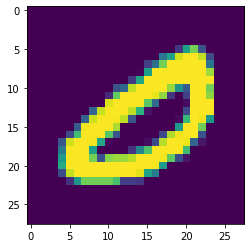

In [13]:
plt.imshow(example_data[0].view(28,28).detach().numpy())

In [81]:
# input_size = 28 * 28 = 784
model = VAE(784, 500, 20)
optimizer = optim.Adagrad(model.parameters(), lr=1e-2)

num_epochs = 20
for epoch in range(num_epochs):
  train(epoch)
  test(epoch)

[1,   100] Train loss: 20986.326
[1,   200] Train loss: 16105.736
[1,   300] Train loss: 15070.960
[1,   400] Train loss: 14477.962
[1,   500] Train loss: 14030.065
[1,   600] Train loss: 13689.535
[1,   100] Test loss: 13393.386
[2,   100] Train loss: 13421.904
[2,   200] Train loss: 13290.443
[2,   300] Train loss: 13054.070
[2,   400] Train loss: 13033.963
[2,   500] Train loss: 12879.618
[2,   600] Train loss: 12742.299
[2,   100] Test loss: 12656.682
[3,   100] Train loss: 12762.029
[3,   200] Train loss: 12716.090
[3,   300] Train loss: 12661.805
[3,   400] Train loss: 12595.447
[3,   500] Train loss: 12559.858
[3,   600] Train loss: 12556.954
[3,   100] Test loss: 12395.341
[4,   100] Train loss: 12538.357
[4,   200] Train loss: 12453.994
[4,   300] Train loss: 12406.548
[4,   400] Train loss: 12434.434
[4,   500] Train loss: 12423.593
[4,   600] Train loss: 12450.919
[4,   100] Test loss: 12265.799
[5,   100] Train loss: 12386.373
[5,   200] Train loss: 12313.010
[5,   300] Tra

In [0]:
sample = torch.randn(1, 20)
sample = model.decode(sample)

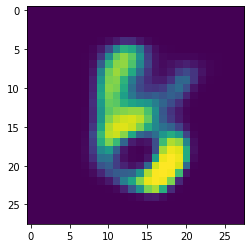

In [85]:
import matplotlib.pyplot as plt
plt.imshow(sample.view(28,28).detach().numpy())